In [1]:
data_path = "/scratch/cl6707/Shared_Datasets/NSD_MindEye"
nsd_root = "/scratch/cl6707/Projects/neuro_interp/data/NSD/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"
subj = 1
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')
sys.path.append('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsd')
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
from datetime import datetime
import webdataset as wds
import PIL
import argparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
from models import Clipper, OpenClipper, BrainNetwork, BrainDiffusionPrior, BrainDiffusionPriorOld, Voxel2StableDiffusionModel, VersatileDiffusionPriorNetwork

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

seed=42
utils.seed_everything(seed=seed)

from torch.utils.data import Dataset
from src.file_utility import load_mask_from_nii, view_data
from src.file_utility import save_stuff, flatten_dict, embed_dict



import struct
import time
from scipy.io import loadmat
from scipy.stats import pearsonr
import pickle
import math
%matplotlib inline
fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
import torch as T
import torch.nn as L
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi
from src.load_nsd import  image_feature_fn, data_split
import h5py
import glob
import torchvision.models as models
from sklearn.decomposition import PCA
from PIL import Image
from src.numpy_utility import mosaic_vis, iterate_minibatches

device: cuda


In [2]:
subj =1
nsd_mindroot = '/scratch/cl6707/Shared_Datasets/NSD_MindEye'
# np.load(nsd_mindroot + '/subj01_things.npy',allow_pickle=True)[2950]
# # nsdgeneral = load_mask_from_nii('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/brainmask.nii.gz')
with h5py.File('/scratch/cl6707/Shared_Datasets/NSD_MindEye/subj01_3D_nsdgeneral.hdf5','r') as f:
    for k in f.keys():
        print(k, f[k].shape)

voxels (27750, 42, 46, 61)


In [3]:
subject= 1
voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%subject)
voxel_roi_full.shape

(81, 104, 83)

In [4]:
from NSDAccess import NSDAccess
nsd = NSDAccess('/scratch/cl6707/Projects/neuro_interp/data/NSD/')

if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386

In [7]:
print('Pulling NSD webdataset data...')
# Multi-GPU config #
from accelerate import Accelerator
accelerator = Accelerator(split_batches=False,mixed_precision='fp16')  
print("PID of this process =",os.getpid())
print = accelerator.print # only print if local_rank=0
device = accelerator.device
print("device:",device)
num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices
print(accelerator.state)
local_rank = accelerator.state.local_process_index
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)



train_url = "{" + f"{data_path}/webdataset_avg_split/train/train_subj0{subj}_" + "{0..17}.tar," + f"{data_path}/webdataset_avg_split/val/val_subj0{subj}_0.tar" + "}"
val_url = f"{data_path}/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
print(train_url,"\n",val_url)
meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982
batch_size = 1
print('Prepping train and validation dataloaders...')
train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
    batch_size,'images',
    num_devices=num_devices,
    num_workers=num_workers,
    train_url=train_url,
    val_url=val_url,
    meta_url=meta_url,
    num_train=num_train,
    num_val=num_val,
    val_batch_size=300,
    cache_dir=data_path, #"/tmp/wds-cache",
    seed=seed,
    voxels_key='nsdgeneral.npy', # 'nsdgeneral.npy' (1d), 'wholebrain_3d.npy'(3d)
    to_tuple=["voxels", "images", "coco","trial"],
    local_rank=local_rank,
    world_size=world_size,
)

Pulling NSD webdataset data...
PID of this process = 2679963
device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1
{/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/train/train_subj01_{0..17}.tar,/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/val/val_subj01_0.tar} 
 /scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/test/test_subj01_{0..1}.tar
Prepping train and validation dataloaders...
Getting dataloaders...

num_train 8859
global_batch_size 1
batch_size 1
num_workers 1
num_batches 8859
num_worker_batches 8859

num_val 982
val_num_batches 982
val_batch_size 300


In [5]:

resnet_model = models.resnet50(pretrained=True)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-1])
resnet_model.eval()
resnet_model = resnet_model.to(device)

def feature_extraction(image_tensor):
    
    image_array = image_tensor.permute(0, 2, 3, 1).squeeze().numpy()
    image_array = (image_array * 255).round().astype(np.uint8)
    #image_array = np.squeeze(image_array, axis=0)  # Remove batch dimension if present
    
    img = Image.fromarray(image_array)
    
    if img.mode != "RGB":
        img = img.convert("RGB")
        
    
    # Apply transformations
    img = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])(img)

    # Normalize the image
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)

    # Add batch dimension (unsqueeze)
    img = img.unsqueeze(0)
    img = img.to(device)


    with torch.no_grad():
        features = resnet_model(img)
        
    features = features.cpu().squeeze().numpy()
    features = features.reshape(1, -1)
    
    return features

/ext3/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ext3/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
all_features = []

for image_tensor in train_dl:
    new_feature = feature_extraction(image_tensor[1])
    all_features.append(new_feature)
for image_tensor in val_dl:
    new_feature = feature_extraction(image_tensor[1])
    all_features.append(new_feature)
    
all_features = np.concatenate(all_features, axis=0)
all_features_array = np.array(all_features)
output_file = '/scratch/cl6707/Projects/neuro_interp/data/NSD/initialfeatures.npy'
np.save(output_file, all_features_array)

TypeError: Cannot handle this data type: (1, 1, 256, 3), |u1

In [ ]:
initial_features = np.load('/scratch/ne2213/projects/IVP/initialfeatures.npy')
pca = PCA(n_components=1)
pca.fit(initial_features.T)
first_principal_component = (pca.components_).T
print(first_principal_component.shape)
print(initial_features.shape)                                                      

(8859, 1)
(8859, 2048)


In [ ]:
n = 0
for image_tensor in train_dl:
    n+=1
print(n)

8859


In [ ]:
train_iterator = iter(train_dl)
updated_samples = []

for i in range(n):
    sample = next(train_iterator)
    voxels, images, coco, trial = sample
    tensor_element = torch.tensor([[first_principal_component[i]]], dtype=torch.float32)
    updated_sample = (voxels, images, coco, trial, tensor_element)
    updated_samples.append(updated_sample)
    
updated_train_dl = torch.utils.data.DataLoader(updated_samples, batch_size=None, num_workers=1, shuffle=False)

<ipython-input-10-ef472a71d797>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  tensor_element = torch.tensor([[first_principal_component[i]]], dtype=torch.float32)


In [11]:
folder_path = '/scratch/ne2213/projects/IVP/Neural_Interpretation-main/notebooks'
file_path = folder_path + '/new_dataloader.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(updated_train_dl, file)

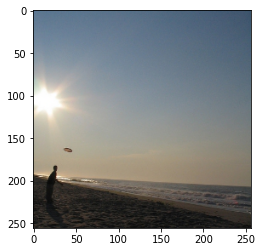

annotation ['A person on a beach with a Frisbee.', 'A man standing on top of a sandy beach under a frisbee.', 'a person on a beach throwing a frisbee', 'a man is on a beach throwing a disc', 'A person standing on a beach with a disc in the air.']
things ['person', 'sports']
torch.Size([1, 3, 15724])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1, 1])
feature =  tensor([[[0.0047]]])


In [14]:
sample = next(iter(updated_train_dl))
annotation = np.load(nsd_mindroot + '/subj%02d_annot.npy'%subj,allow_pickle=True)
things = np.load(nsd_mindroot + '/subj%02d_things.npy'%subj,allow_pickle=True)

voxels, images, coco, trial, feature = sample
   
plt.imshow(images[0].permute(1,2,0))
plt.show()
print("annotation",annotation[trial[0]])
print("things",things[trial[0]])

for s in sample:
    print(s.shape)
    
print('feature = ', feature)

In [15]:
with open(file_path, 'rb') as file:
    loaded_train_dl = pickle.load(file)

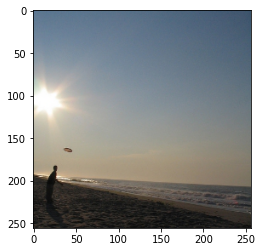

annotation ['A person on a beach with a Frisbee.', 'A man standing on top of a sandy beach under a frisbee.', 'a person on a beach throwing a frisbee', 'a man is on a beach throwing a disc', 'A person standing on a beach with a disc in the air.']
things ['person', 'sports']
torch.Size([1, 3, 15724])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1, 1])
feature =  tensor([[[0.0047]]])


In [16]:
sample = next(iter(loaded_train_dl))
annotation = np.load(nsd_mindroot + '/subj%02d_annot.npy'%subj,allow_pickle=True)
things = np.load(nsd_mindroot + '/subj%02d_things.npy'%subj,allow_pickle=True)

voxels, images, coco, trial, feature = sample
   
plt.imshow(images[0].permute(1,2,0))
plt.show()
print("annotation",annotation[trial[0]])
print("things",things[trial[0]])

for s in sample:
    print(s.shape)
    
print('feature = ', feature)